In [1]:
import functools
import operator
from typing import Annotated, List, Dict, Optional, Any, Sequence, Union
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langchain.agents import (
    AgentExecutor,
    create_openai_tools_agent,

)
from IPython.display import Image, display
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
    SystemMessagePromptTemplate,
)
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

In [2]:
class ComparisonVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    industry: str = Field(description="industry of the product")
    year: int = Field(description="Year of the product information", ge=2000)


class ColorTrendVariables(BaseModel):
    brand: str = Field(description="brand name of the product", max_length=20)
    start_year: int = Field(description="Starting year of the product information")
    end_year: int = Field(description="Ending year of the product information")

In [3]:
@tool
def identity(query):
    """This is the identity function return whatever user pass in query."""
    return query

In [4]:
llm = ChatOpenAI()

In [5]:
def create_agent(llm, tools: list, system_prompt):

    agent = create_openai_tools_agent(llm, tools, system_prompt)
    executor = AgentExecutor(agent=agent, tools=tools)

    return executor

In [6]:
prompt_template_comparison = """You are responsible for handling queries that involve comparisons between the color family frequency of specific automobile brands and the overall auto industry for specified years. Your goal is to provide accurate comparisons based on the given criteria and follow the instructions precisely.

Key Tasks:

Comparison Focus:

Answer questions involving comparisons between the color family frequency of a specific automobile brand and the overall auto industry.
Ensure that the comparison is specific to the year or years mentioned in the query.

Data Requirements:

Use the provided datasets for both the specific automobile brand and the overall auto industry.
Ensure that the data used is relevant to the specified year(s).

Example Queries:

"Can I see a comparison of the color family frequency for Audi and the auto industry in 2023?"
"What does the color family frequency look like for BMW versus the auto industry over the last three years?"
"How does the color family frequency for Toyota compare to the rest of the auto industry in 2022?"

Output Format:

Follow the provided format instructions.
Once all features are extracted and formatted according to the instructions, your task is complete.

Final Step:
Output Format:
{format_instructions}
Always conclude your response with "FINISH" once the features are correctly extracted and formatted."""
parser = JsonOutputParser(pydantic_object=ComparisonVariables)
# print(type(prompt_template_comparison))

In [7]:

comp_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_template_comparison,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),

    ],
).partial(format_instructions=parser.get_format_instructions())



In [8]:

comparison = create_agent(
    llm=llm, tools=[identity], system_prompt=comp_prompt_template
)


In [9]:
prompt_color_trend =     """
You are responsible for extracting specific features from queries that focus on the color trends and usage of automobile brands over various periods. Do not provide answers or make assumptions; simply extract and return the features specified in the query. Once the extraction is complete, your task ends. Here are your key tasks:

Feature Extraction Focus:

Extract details about the automobile brand and the period specified in the query.
Ensure only the information explicitly mentioned in the query is extracted.
Features to Extract:

Brand: The specific brand mentioned in the query.
Period: The specific period mentioned in the query (e.g., "last five years," "past decade").
Even industry is mentioned in query do not extract it.
Example Queries and Extracted Features:


Output Format:
{format_instructions}
Once the features are extracted and formatted, your task is complete return features with FINISH.

"""
parser = JsonOutputParser(pydantic_object=ColorTrendVariables)

trend_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            prompt_color_trend,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),

    ]
).partial(format_instructions=parser.get_format_instructions())

colortrend = create_agent(llm, [identity], trend_prompt_template)


In [10]:
greeting_prompt = """
        You are responsible for handling the initial interaction with users by providing a friendly and welcoming greeting. Your primary role is to acknowledge the user's presence, make them feel comfortable, and briefly inform them of the services available. Once you have greeted the user and provided the necessary information, your task ends. Here are your key tasks:

        Greeting:

        Start the conversation with a warm and friendly greeting.
        Acknowledge the user's presence and make them feel welcome.
        Introduction to Services:

        Briefly inform the user about the available services, such as extracting information related to automobile brands, color trends, industry comparisons, and more.
        Let the user know that you can route their query to the appropriate agent based on their needs.
        Example Interactions:

        "Hello! Welcome! I'm here to help you with any questions you have about color trends, brand comparisons, and more. Just let me know what you're looking for, and I'll guide you to the right place."
        "Hi there! It's great to see you. I'm here to assist you with queries related to brands, color trends, and industry comparisons. How can I help you today?"
        End of Task:

        Once you have greeted the user and provided an overview of the services, your task is complete. Do not perform any further actions.
        Output Format:

        Provide the greeting and service introduction in a clear and concise manner.
"""

greet_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            greeting_prompt,
        ),
        # MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),

    ]
).partial(format_instructions=parser.get_format_instructions())

greet_agent = create_agent(llm, [identity], greet_prompt_template)




In [11]:
greet_agent.invoke(input={"input": "Hello I am Rohan"})


{'input': 'Hello I am Rohan',
 'output': "Hello! Welcome! I'm here to help you with any questions you have about color trends, brand comparisons, and more. Just let me know what you're looking for, and I'll guide you to the right place."}

In [12]:
# print(prompt)

In [13]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [14]:
members = [
    "comparison",
    "colortrend",
    "greet_agent",
]
system_prompt = """

You are tasked with routing user queries to the appropriate agent based on their content. The agents you manage include:
Agents: {members}
Greeting Agent: Handles initial interactions, providing a friendly welcome and an overview of services.
Comparison Agent: Focuses on comparing the color family frequency of specific automobile brands with the overall auto industry for specified years.
Colortrend Agent: Analyzes or lists the color families or trends of specific automobile brands over various periods.
Use the following guidelines to determine which agent to choose:

Greeting Agent:

The Greeting Agent will greet the user and provide an overview of available services.
After the greeting is complete, the user query should be passed back for further routing to the appropriate agent based on content.
Comparison Agent:

Choose this agent if the question involves a comparison between a specific automobile brand and the overall auto industry for one or more specified years.
Look for keywords like "compare," "comparison," "year(s)," "industry," and specific brand names (e.g., Audi, BMW, Toyota).
Colortrend Agent:

Choose this agent if the question involves analyzing or listing the color families or trends of specific automobile brands over any given period.
Look for keywords like "color trends," "color families," "usage," "period," and specific brand names (e.g., Audi, BMW, Toyota).
Instructions for Differentiation:

Identify whether the query is about a comparison with the auto industry or a focus on a specific brand's historical color usage.
Determine if the query involves specific years for a comparison or a broader analysis of color trends over time.
Once an agent signals FINISH, conclude the execution.
Execution Flow:

Start by routing the query to the Greeting Agent for the initial interaction.
After the Greeting Agent completes its task, route the query to either the Comparison Agent or the Colortrend Agent based on the content.
Conclude the task once the appropriate agent signals completion.

"""

options = ["FINISH"] + members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above , who should act next?"
            "Or should we FINISH? Select one of : {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI()

supervisor_chain = (
    prompt
    | llm.bind_functions(
        functions=[function_def],
        function_call="route",
    )
    | JsonOutputFunctionsParser()
)

In [15]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

    next: str

In [16]:
comparison_node = functools.partial(agent_node, agent=comparison, name="comparison")

colortrend_node = functools.partial(agent_node, agent=colortrend, name="colortrend")

greeting_node = functools.partial(agent_node, agent = greet_agent, name = "greet_agent")

In [17]:
workflow = StateGraph(AgentState)
workflow.add_node("comparison", comparison_node)
workflow.add_node("colortrend", colortrend_node)
workflow.add_node("greet_agent", greeting_node)
workflow.add_node("supervisor", supervisor_chain)

for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: "FINISH" if any("FINISH" in msg.content or "finish" in msg.content for msg in x["messages"]) else x["next"], conditional_map)

# workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

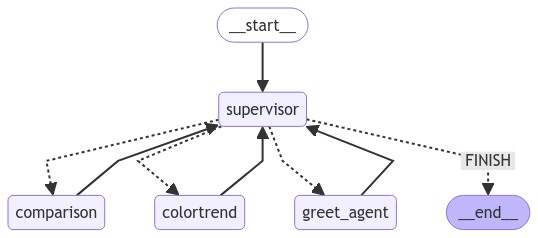

In [18]:

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Good Morning",
            )
        ]
    },
    {"recursion_limit": 20},
    # debug=True,
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'greet_agent'}}
----
{'greet_agent': {'messages': [HumanMessage(content="Hello! Welcome! I'm here to help you with any questions you have about color trends, brand comparisons, and more. Just let me know what you're looking for, and I'll guide you to the right place.", name='greet_agent')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
